In [1]:
import os, sys, shutil
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
import tqdm


from glob import glob
from rasterio.warp import transform_bounds
from shapely.geometry import Polygon
from pyproj import Transformer
from matplotlib import pyplot as plt

module_path = os.path.abspath(".") + "/code"
if module_path not in sys.path:
    sys.path.append(module_path)

from dataset import load_scenario
from Scenario_sampler import ScenarioSampler

In [3]:
# utils

def return_first_scenario(path):
    chosen_subfolder = None
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_dir() and entry.name != '.DS_Store':
                chosen_subfolder = entry.name
                break
    if chosen_subfolder is None:
        raise ValueError("No subfolder found")
    return chosen_subfolder



def read_first_and_last_lines(file_path):
    with open(file_path, 'rb') as file:
        # Read the first line
        first_line = file.readline().decode()

        # Move to the end of the file
        file.seek(0, os.SEEK_END)
        file_size = file.tell()
        if file_size == 0:
            return '', ''  # Empty file

        pos = file_size - 1

        # Skip trailing newlines at the end of the file
        while pos >= 0:
            file.seek(pos, os.SEEK_SET)
            char = file.read(1)
            if char != b'\n' and char != b'\r':
                break
            pos -= 1

        # Now find the previous newline (start of last line)
        while pos >= 0:
            file.seek(pos, os.SEEK_SET)
            if file.read(1) == b'\n':
                pos += 1
                break
            pos -= 1
        else:
            pos = 0  # The last line is also the first line

        file.seek(pos, os.SEEK_SET)
        last_line = file.readline().decode()

    return first_line, last_line


def read_first_and_last_lines2(file_path):
    with open(file_path, 'r') as file:
        # Read the first line
        first_line = file.readline()

        # Move to the end of the file
        file.seek(-1, 2)  # 2 means seek from the end

        # Read until a newline is found
        last_line = ''
        while True:
            char = file.read(1)
            if char == '\n' or file.tell() == 1:
                break
            last_line = char + last_line
            file.seek(-2, 1)  # Move back two characters

    return first_line, last_line

from datetime import datetime
def find_earliest_latest_dates(layout_path):
    """
    Find the earliest and latest dates in a layout folder.
    """
    earliest_date = None
    latest_date = None
    for filename in os.listdir(os.path.join(layout_path, "Weather_Data")):
        if filename.endswith(".txt"):
            first_line, last_line = read_first_and_last_lines(os.path.join(layout_path, "Weather_Data", filename))
            first_date = " ".join(first_line.split(" ")[:4])
            last_date = " ".join(last_line.split(" ")[:4])
            first_date = datetime.strptime(first_date, "%Y %m %d %H%M")
            last_date = datetime.strptime(last_date, "%Y %m %d %H%M")
            if earliest_date is None or first_date < earliest_date:
                earliest_date = first_date
            if latest_date is None or last_date > latest_date:
                latest_date = last_date
    return earliest_date, latest_date

In [4]:
new_fires_gdf = gpd.read_file("./newfires.gpkg") # 6th edition # gpd.read_file("./FPA_FOD_20210617.gpkg") 5th edition  
# replace illegal dates by jan first 1900
new_fires_gdf['DISCOVERYDATETIME'] = new_fires_gdf['DISCOVERYDATETIME'].replace('1001/01/01 00:00:00+00', '1900/01/01 00:00:00+00')
new_fires_gdf['DISCOVERY_DATE'] = pd.to_datetime(new_fires_gdf['DISCOVERYDATETIME'])
new_fires_gdf['DISCOVERY_DATE'].dt.date
new_fires_gdf['LONGITUDE'] = new_fires_gdf['LONGDD83']
new_fires_gdf['LATITUDE'] = new_fires_gdf['LATDD83']
new_fires_gdf = new_fires_gdf.to_crs("EPSG:4326")
print(len(new_fires_gdf)) # 

old_fires_gdf = gpd.read_file("./FPA_FOD_20221014.gpkg")
old_fires_gdf['OBJECTID'] = old_fires_gdf['FOD_ID']
old_fires_gdf = old_fires_gdf.to_crs("EPSG:4326")
print(len(old_fires_gdf)) # 2 303 566

# merge the two gdfs
fires_gdf = pd.concat([new_fires_gdf, old_fires_gdf])
print(len(fires_gdf)) 

# drop duplicates as defined as same lat, long and same date
fires_gdf = fires_gdf.drop_duplicates(subset=['LATITUDE', 'LONGITUDE', 'DISCOVERY_DATE'])
print(len(fires_gdf)) 

# fires_gdf = new_fires_gdf.to_crs("EPSG:4326")
# print(len(fires_gdf))

582291


/opt/anaconda3/envs/wildfire/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'FPA_FOD_20221014.gpkg': 'Fires' (default), 'NWCG_UnitIdActive_20200123'. Specify layer parameter to avoid this warning.
  result = read_func(


2303566
2885857
2843606


Copied the layout tifs to sim2real_layouts
loaded the layout list
loaded the fires


  0%|          | 0/72 [00:00<?, ?it/s]

0025_02019


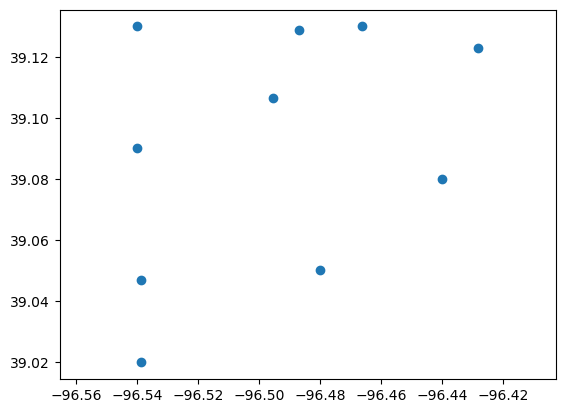

Sampler built with 167567 ignition points.


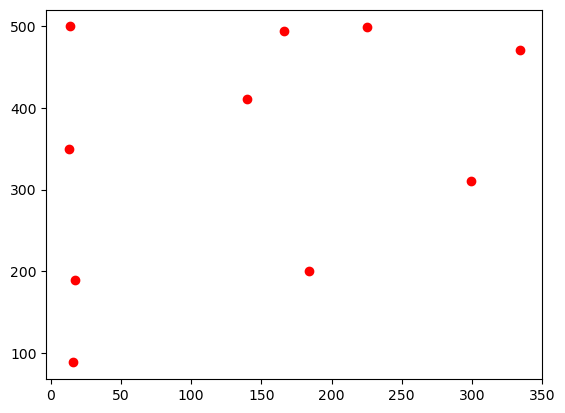

  1%|▏         | 1/72 [00:06<07:52,  6.65s/it]

Failed 0
0344_03155
No fires found for layout 0344_03155
0024_02655


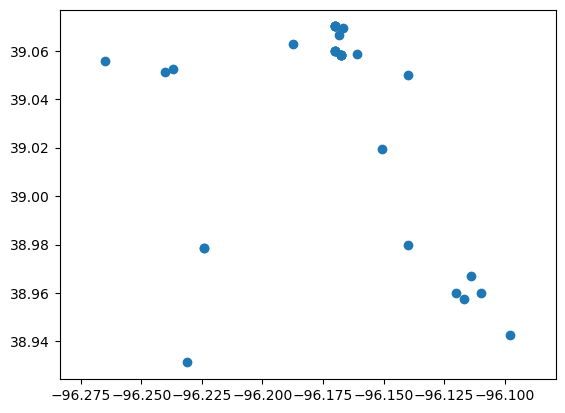

Sampler built with 207530 ignition points.


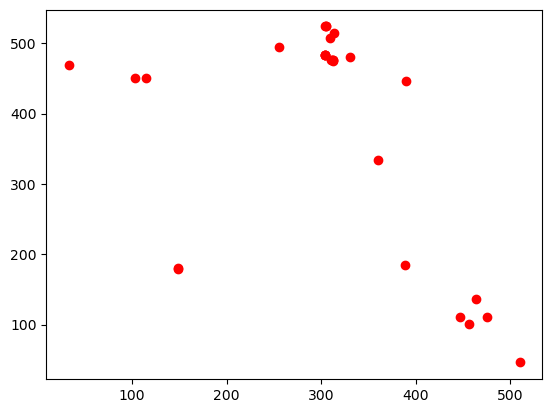

  4%|▍         | 3/72 [00:56<23:21, 20.31s/it]

Failed 3
0106_02165
Layout ./WideDataset/0106_02165/Satellite_Images_Mask/ does not exist


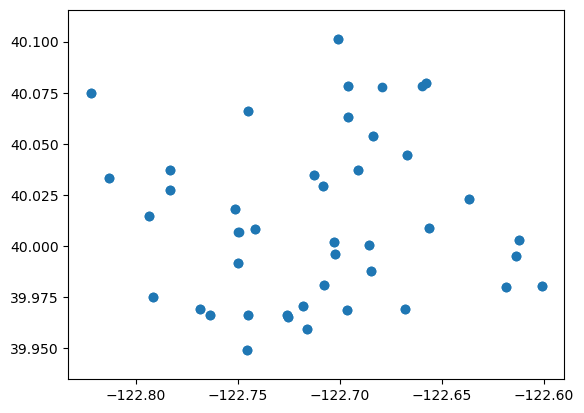

Error processing 0106_00530: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00530/
Error processing 0106_00487: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00487/
Error processing 0106_00486: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00486/
Error processing 0106_00488: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00488/
Error processing 0106_01644: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_01644/
Error processing 0106_01643: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_01643/
Error processing 0106_00753: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00753/
Error processing 0106_00754: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00754/
Error processing 0106_00755: No JPG files found in folder: ./Wid

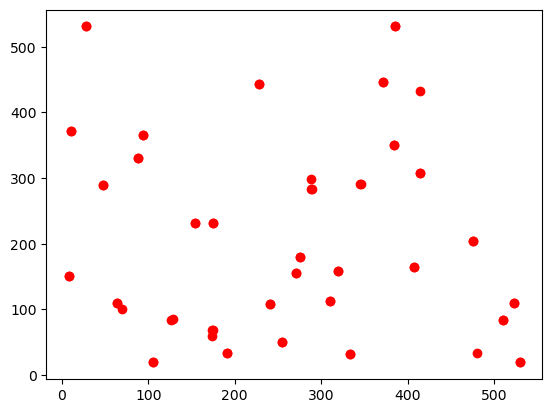

  6%|▌         | 4/72 [01:35<30:15, 26.70s/it]

Failed 15
0092_03189


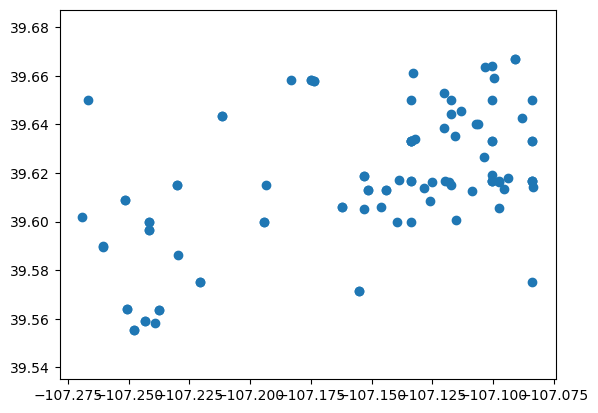

Sampler built with 72368 ignition points.


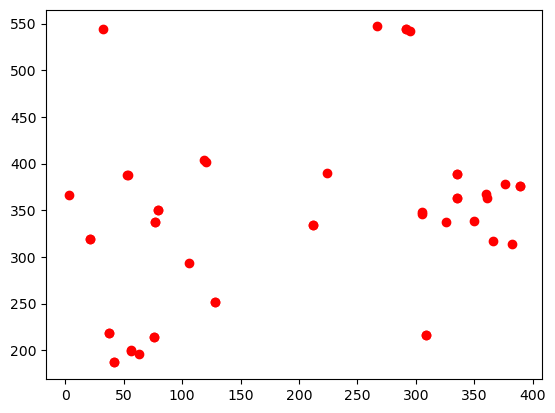

  7%|▋         | 5/72 [02:22<37:14, 33.35s/it]

Failed 53
!! Failed 53 out of 101 for layout 0092_03189 !!
0111_03612
Layout ./WideDataset/0111_03612/Satellite_Images_Mask/ does not exist


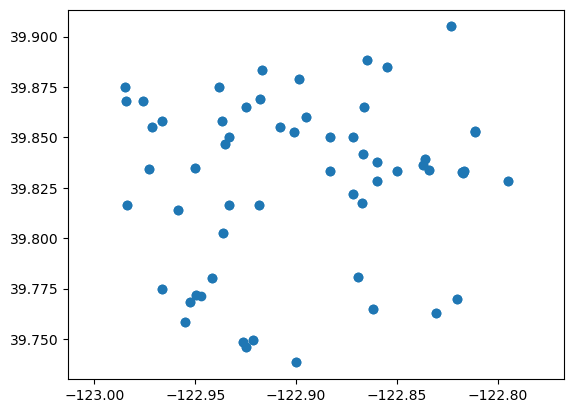

Error processing 0111_02486: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_02486/
Error processing 0111_02488: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_02488/
Error processing 0111_01266: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_01266/
Error processing 0111_01268: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_01268/
Error processing 0111_02487: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_02487/
Error processing 0111_01267: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_01267/
Error processing 0111_00001: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_00001/
Error processing 0111_00431: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_00431/
Error processing 0111_01187: No JPG files found in folder: ./Wid

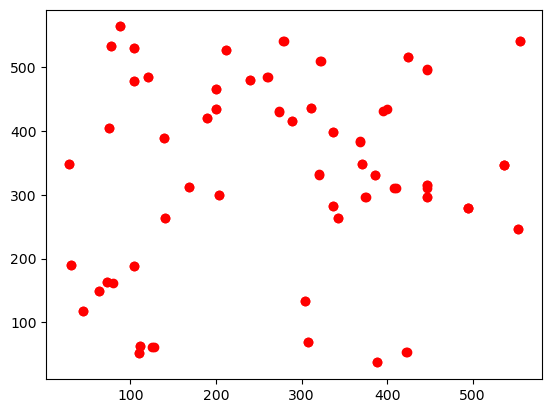

  8%|▊         | 6/72 [03:49<55:34, 50.52s/it]

Failed 9
0023_00995


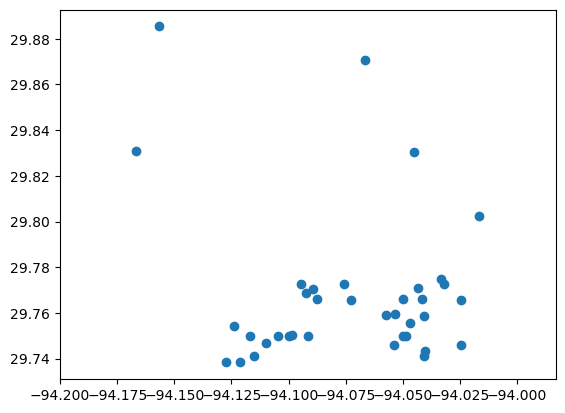

Sampler built with 79841 ignition points.


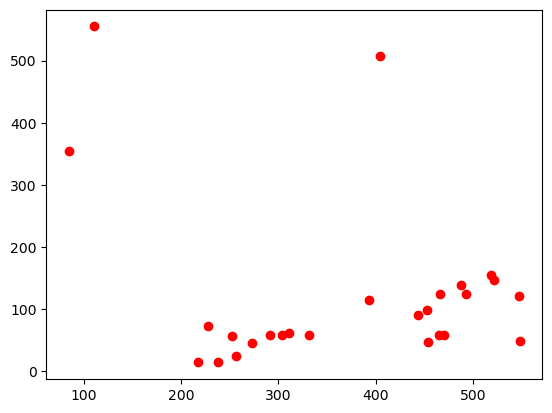

 10%|▉         | 7/72 [04:09<44:21, 40.95s/it]

Failed 11
!! Failed 11 out of 37 for layout 0023_00995 !!
0089_00984


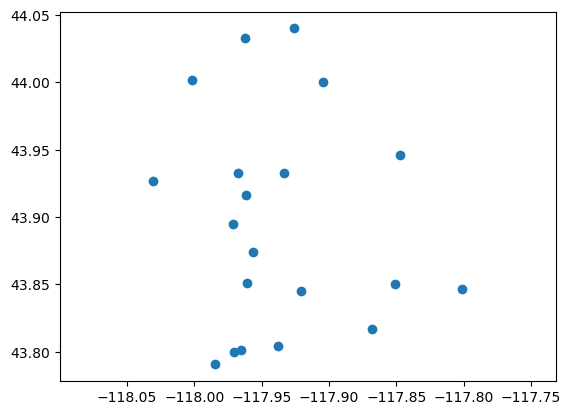

Sampler built with 22261 ignition points.
Scenario 0089_00777 has the wrong size for layout 0089_00984: 583 != 559 or 931 != 479


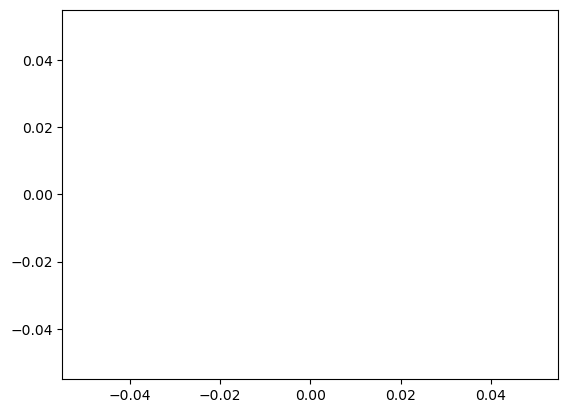

 11%|█         | 8/72 [04:26<35:50, 33.60s/it]

Failed 0
0104_02422
Layout ./WideDataset/0104_02422/Satellite_Images_Mask/ does not exist


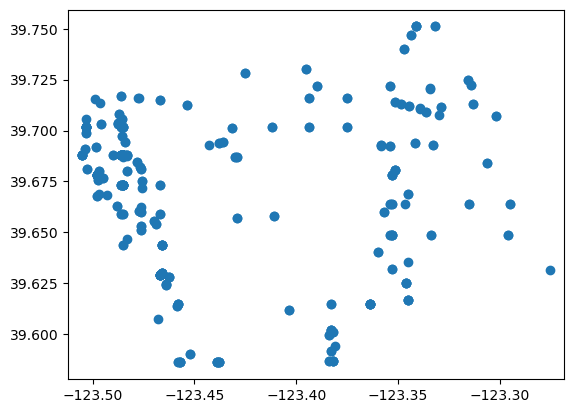

Error processing 0104_00224: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_00224/
Error processing 0104_00223: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_00223/
Error processing 0104_00225: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_00225/
Error processing 0104_01125: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_01125/
Error processing 0104_01124: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_01124/
Error processing 0104_01123: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_01123/
Error processing 0104_02085: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_02085/
Error processing 0104_00124: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_00124/
Error processing 0104_02084: No JPG files found in folder: ./Wid

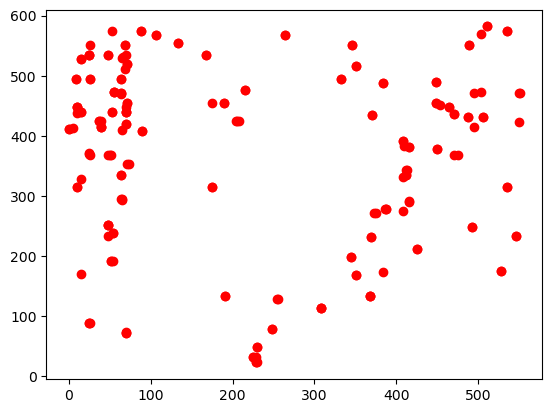

 12%|█▎        | 9/72 [05:04<36:33, 34.82s/it]

Failed 152
!! Failed 152 out of 356 for layout 0104_02422 !!
0041_02386


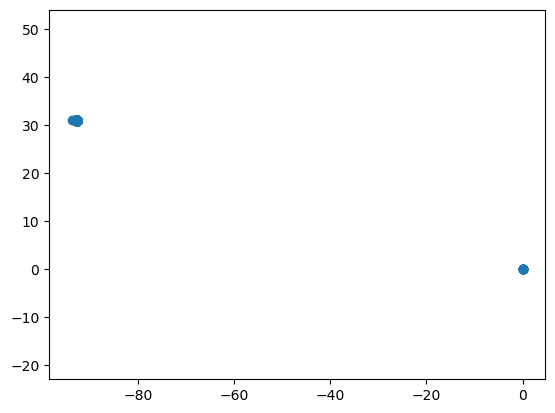

In [ ]:
# Get the layout coordinates 
# 1 extract the tif files
dataset_path = "./WideDataset/"

# copy the layout tifs from a folder to a folder called sim2real_layout
tif_path = "sim2real_layouts"
os.makedirs(tif_path, exist_ok=True)
for folder in os.listdir(dataset_path):
    if folder == ".DS_Store":
        continue
    shutil.copy(f"WideDataset/{folder}/Vegetation_Map/Existing_Vegetation_Cover.tif", f"{tif_path}/{folder}_Existing_Vegetation_Cover.tif")

print("Copied the layout tifs to sim2real_layouts")
####

tif_files = glob(os.path.join(tif_path, "*.tif"))
layout_list = []
widths = []
names = []
for tif_file in tif_files:
    with rasterio.open(tif_file) as dataset:
        # get the file name without the path
        file_name = os.path.basename(tif_file)  # '0004_Elevation.tif'
        identifier = "_".join(file_name.split('_')[:2])

        # extract the resolution, check it is 30
        x_resolution = dataset.transform[0]
        y_resolution = -dataset.transform[4]
        assert x_resolution == y_resolution == 30, f"Resolution is not the same: {x_resolution} != {y_resolution}"

        # extract the coordinates using the bounds
        # /!\ DO NOT USE transform_bounds(dataset.crs, 'EPSG:4326', *dataset.bounds)
        x_min = dataset.bounds[0]
        x_max = dataset.bounds[2]
        y_min = dataset.bounds[1]
        y_max = dataset.bounds[3]

        transformer = Transformer.from_crs(dataset.crs, "EPSG:4326", always_xy=True)
        lat_top_left, lon_top_left = transformer.transform(x_min, y_max)
        lat_top_right, lon_top_right = transformer.transform(x_max, y_max)
        lat_bottom_left, lon_bottom_left = transformer.transform(x_min, y_min)
        lat_bottom_right, lon_bottom_right = transformer.transform(x_max, y_min)

        # Create the polygon using the transformed bounds
        polygon = Polygon((
            (lat_top_left, lon_top_left),
            (lat_top_right, lon_top_right),
            (lat_bottom_right, lon_bottom_right),
            (lat_bottom_left, lon_bottom_left),
            (lat_top_left, lon_top_left)  # close the polygon
        ))

        layout_list.append({
            'identifier': identifier,
            'height': dataset.height,
            'width': dataset.width,
            'geometry': polygon,
            'transformer': transformer,
            'dataset': dataset
        })


        widths.append(dataset.width)
        names.append(identifier)

sorted_indices = np.argsort(widths)
widths = np.array(widths)[sorted_indices]
names = np.array(names)[sorted_indices]
filtered_layout_list = [layout_list[i] for i in sorted_indices]

n_small_layouts = len(widths[widths < 500])
n_medium_layouts = len(widths[(widths >= 500) & (widths < 1000)])
n_large_layouts = len(widths[widths >= 1000])

small_layouts = filtered_layout_list[:n_small_layouts]
medium_layouts = filtered_layout_list[n_small_layouts:n_small_layouts + n_medium_layouts]
large_layouts = filtered_layout_list[n_small_layouts + n_medium_layouts:]

selected_layouts = medium_layouts + large_layouts
widths = widths[-len(selected_layouts):]
names = names[-len(selected_layouts):]


print("loaded the layout list")
# move the samll layouts to the small folder
os.makedirs("small_layouts", exist_ok=True)
for layout in small_layouts:
    #print(os.path.join(dataset_path, layout['identifier']), os.path.join("small_layouts", layout['identifier']))
    try:
        shutil.move(os.path.join(dataset_path, layout['identifier']), os.path.join("small_layouts", layout['identifier']))
    except Exception as e:
       # file already moved
       pass


# convert the layout list to a geopandas df
layout_list = selected_layouts
gdf = gpd.GeoDataFrame(layout_list, geometry='geometry', crs="EPSG:4326")




# Load the historical fires 
# fires_gdf = gpd.read_file("./FPA_FOD_20210617.gpkg")
# fires_gdf = fires_gdf.to_crs("EPSG:4326")
print("loaded the fires")


# Joint
# Spatial join: find which points fall into which polygons
joined = gpd.sjoin(fires_gdf, gdf, how='inner', predicate='within')


# Count points per polygon
counts = joined.groupby('identifier').size().reset_index(name='fire_count')


dataset_path = "./WideDataset/"
scenario_path_suffix = "/Satellite_Images_Mask/"

failed_layouts = []
continue_out = False
processed = total = 0

for layout_name in tqdm.tqdm(names):
    total+=1
    print(layout_name)
    try:
        layout_folder = dataset_path + layout_name + scenario_path_suffix
        # check the layout folder exists
        if not os.path.exists(layout_folder):
            print(f"Layout {layout_folder} does not exist")
            layout_folder = dataset_path + layout_name +  "/Satellite_Image_Mask/"
            if not os.path.exists(layout_folder):
                print(f"Layout {layout_folder} does not exist")
                failed_layouts.append(layout_name)
                continue
        
        if os.path.exists(f"./WideDataset/{layout_name}/selected_scenarios_full_match.txt"):
            processed +=1
            #continue

        # check that the scenario have the right size
        first_scenario = return_first_scenario(layout_folder)
        if first_scenario is None:
            print(f"Layout {layout_name} does not have any scenario")
            failed_layouts.append(layout_name)
            continue
        
        first_loaded_scenario = load_scenario(os.path.join(layout_folder, first_scenario), extension = '.jpg', first_frame_only=True)
        height_scenario, width_scenario = first_loaded_scenario.shape[0], first_loaded_scenario.shape[1]

        data = joined[joined['identifier'] == layout_name]
        if len(data) == 0:
            print(f"No fires found for layout {layout_name}")
            failed_layouts.append(layout_name)
            continue
        plt.scatter(data["LONGITUDE"], data["LATITUDE"])
        plt.axis("equal")
        plt.show()

        #earliest_date, latest_date = find_earliest_latest_dates(dataset_path + layout_name)
        #print(f"Earliest date: {earliest_date}, Latest date: {latest_date}")


        sampler = ScenarioSampler(layout_folder, extension = '.jpg')
        sampled_scenarios = []
        sampled_ignition_points = []
        associated_fires = []
        date_matched = []
        distances = []
        failed = 0
        # plot the historical fires
        

        # start with the fires that have potewntial to be test fires, i.e their date is between the earliest and latest date
        # We will have one "test" dataset, one "train" dataset, and one extra train dataset for the test fires
        # filtered_data = data[
        # (data['DISCOVERY_DATE'].dt.date >= earliest_date.date()) & 
        # (data['DISCOVERY_DATE'].dt.date <= latest_date.date())
        # ]
        

        for i, fire in data.iterrows():
            # print the coordinates of the fire
            width, height = fire['width'], fire['height']
            # check that the scenario have the right size
            if width != width_scenario or height != height_scenario:
                print(f"Scenario {first_scenario} has the wrong size for layout {layout_name}: {width} != {width_scenario} or {height} != {height_scenario}")
                failed_layouts.append(layout_name)
                break
            dataset = fire['dataset']
            transformer = fire['transformer']
            x_fire, y_fire = transformer.transform(fire['LONGITUDE'], fire['LATITUDE'], direction='INVERSE')
            row, col = rasterio.transform.rowcol(dataset.transform, x_fire, y_fire)
            # print("row, col", row, col)
            ignition_point = (col, row)
            sample, sampled_ignition_point = sampler.get_scenario_location(ignition_point, leeway_distance=5, sampling_method='closest', exclude_scenarios=sampled_scenarios)
            if sample is None:
                failed += 1
                continue
            sampled_scenarios.append(sample)
            sampled_ignition_points.append(sampled_ignition_point)
            associated_fires.append(fire['OBJECTID'])
            distance = abs(sampled_ignition_point[0] - ignition_point[0]) + abs(sampled_ignition_point[1] - ignition_point[1])
            distances.append(distance)
        # plot the sampled scenarios
        # the axes are inverted as coordinates start in (0,0) in the top left corner
        fig, ax = plt.subplots()
        ax.scatter([point[0] for point in sampled_ignition_points], [width - point[1] for point in sampled_ignition_points], color='red')
        plt.show()
        print(f"Failed {failed}")
        # write the selected scenarios in a txt file
        with open(f"./WideDataset/{layout_name}/selected_scenarios.txt", "w") as f:
            for scenario, fire_id in zip(sampled_scenarios, associated_fires):
                f.write(f"{scenario}, {fire_id}\n")
            f.write(f"Failed: {failed}\n")
            failed_percentage = failed / max(len(data),1)
            f.write(f"Failed percentage: {failed_percentage}\n")
        if len(data) == 0 or failed_percentage > 0.2:
            print(f"!! Failed {failed} out of {len(data)} for layout {layout_name} !!")
            failed_layouts.append(layout_name)
    except Exception as e:
        print(f"Error for layout {layout_name}: {e}")
        failed_layouts.append(layout_name)
print(processed)
print(total)
    

# TODO do we need to create the grid manually? I think the raster file will doirectly give you the coordinates within the layout


# for each fire, sample the scenario (space only, and time+space)
# write the identifier in a txt file (one for space only, one for time+space)

# move the scenarios into a selected folder
# "delete" the other scenarios

# train test split with the date












# same with date

In [ ]:
from Scenario_sampler import ScenarioSamplerDate
# Get the layout coordinates 
# 1 extract the tif files
dataset_path = "./WideDataset/"

# copy the layout tifs from a folder to a folder called sim2real_layout
tif_path = "sim2real_layouts"
os.makedirs(tif_path, exist_ok=True)
for folder in os.listdir(dataset_path):
    if folder == ".DS_Store":
        continue
    shutil.copy(f"WideDataset/{folder}/Vegetation_Map/Existing_Vegetation_Cover.tif", f"{tif_path}/{folder}_Existing_Vegetation_Cover.tif")

print("Copied the layout tifs to sim2real_layouts")
####

tif_files = glob(os.path.join(tif_path, "*.tif"))
layout_list = []
widths = []
names = []
for tif_file in tif_files:
    with rasterio.open(tif_file) as dataset:
        # get the file name without the path
        file_name = os.path.basename(tif_file)  # '0004_Elevation.tif'
        identifier = "_".join(file_name.split('_')[:2])

        # extract the resolution, check it is 30
        x_resolution = dataset.transform[0]
        y_resolution = -dataset.transform[4]
        assert x_resolution == y_resolution == 30, f"Resolution is not the same: {x_resolution} != {y_resolution}"

        # extract the coordinates using the bounds
        # /!\ DO NOT USE transform_bounds(dataset.crs, 'EPSG:4326', *dataset.bounds)
        x_min = dataset.bounds[0]
        x_max = dataset.bounds[2]
        y_min = dataset.bounds[1]
        y_max = dataset.bounds[3]

        transformer = Transformer.from_crs(dataset.crs, "EPSG:4326", always_xy=True)
        lat_top_left, lon_top_left = transformer.transform(x_min, y_max)
        lat_top_right, lon_top_right = transformer.transform(x_max, y_max)
        lat_bottom_left, lon_bottom_left = transformer.transform(x_min, y_min)
        lat_bottom_right, lon_bottom_right = transformer.transform(x_max, y_min)

        # Create the polygon using the transformed bounds
        polygon = Polygon((
            (lat_top_left, lon_top_left),
            (lat_top_right, lon_top_right),
            (lat_bottom_right, lon_bottom_right),
            (lat_bottom_left, lon_bottom_left),
            (lat_top_left, lon_top_left)  # close the polygon
        ))

        layout_list.append({
            'identifier': identifier,
            'height': dataset.height,
            'width': dataset.width,
            'geometry': polygon,
            'transformer': transformer,
            'dataset': dataset
        })


        widths.append(dataset.width)
        names.append(identifier)

sorted_indices = np.argsort(widths)
widths = np.array(widths)[sorted_indices]
names = np.array(names)[sorted_indices]
filtered_layout_list = [layout_list[i] for i in sorted_indices]

n_small_layouts = len(widths[widths < 500])
n_medium_layouts = len(widths[(widths >= 500) & (widths < 1000)])
n_large_layouts = len(widths[widths >= 1000])

small_layouts = filtered_layout_list[:n_small_layouts]
medium_layouts = filtered_layout_list[n_small_layouts:n_small_layouts + n_medium_layouts]
large_layouts = filtered_layout_list[n_small_layouts + n_medium_layouts:]

print("loaded the layout list")


# convert the layout list to a geopandas df
gdf = gpd.GeoDataFrame(layout_list, geometry='geometry', crs="EPSG:4326")




# Load the historical fires 
# fires_gdf = gpd.read_file("./FPA_FOD_20210617.gpkg")
# fires_gdf = fires_gdf.to_crs("EPSG:4326")
print("loaded the fires")


# Joint
# Spatial join: find which points fall into which polygons
joined = gpd.sjoin(fires_gdf, gdf, how='inner', predicate='within')


# Count points per polygon
counts = joined.groupby('identifier').size().reset_index(name='fire_count')


dataset_path = "./WideDataset/"
scenario_path_suffix = "/Satellite_Images_Mask/"

failed_layouts = []
processed_layouts = []
continue_out = False
processed = total = 0

for layout_name in names:
    total+=1
    print(layout_name)
    try:
        layout_folder = dataset_path + layout_name + scenario_path_suffix
        # check the layout folder exists
        if not os.path.exists(layout_folder):
            print(f"Layout {layout_folder} does not exist")
            layout_folder = dataset_path + layout_name +  "/Satellite_Image_Mask/"
            if not os.path.exists(layout_folder):
                print(f"Layout {layout_folder} does not exist")
                failed_layouts.append(layout_name)
                continue
        
        if os.path.exists(f"./WideDataset/{layout_name}/selected_scenarios.txt"):
            processed +=1
            #continue

        # check that the scenario have the right size
        first_scenario = return_first_scenario(layout_folder)
        if first_scenario is None:
            print(f"Layout {layout_name} does not have any scenario")
            failed_layouts.append(layout_name)
            continue
        
        first_loaded_scenario = load_scenario(os.path.join(layout_folder, first_scenario), extension = '.jpg', first_frame_only=True)
        height_scenario, width_scenario = first_loaded_scenario.shape[0], first_loaded_scenario.shape[1]

        earliest_date, latest_date = find_earliest_latest_dates(dataset_path + layout_name)

        if earliest_date.year > 2020:
            print(f"Layout {layout_name} has no fires before 2021: {earliest_date}")
            failed_layouts.append(layout_name)
            continue

        # plot the historical fires
        data = joined[joined['identifier'] == layout_name]

        filtered_data = data[
        (data['DISCOVERY_DATE'].dt.date >= earliest_date.date()) & 
        (data['DISCOVERY_DATE'].dt.date <= latest_date.date())
        ]

        if len(filtered_data) == 0:
            print(f"No fires found for layout {layout_name} between {earliest_date} and {latest_date}")
            print("example  fire date:", data['DISCOVERY_DATE'].iloc[0])
            failed_layouts.append(layout_name)
            continue

        sampler = ScenarioSamplerDate(layout_folder, extension = '.jpg')
        sampled_scenarios = []
        sampled_ignition_points = []
        sampled_ignition_dates = []
        associated_fires = []
        date_matched = []
        distances = []
        failed = 0
        

        plt.scatter(filtered_data["LONGITUDE"], filtered_data["LATITUDE"])
        plt.axis("equal")
        plt.show()

        # start with the fires that have potewntial to be test fires, i.e their date is between the earliest and latest date
        # We will have one "test" dataset, one "train" dataset, and one extra train dataset for the test fires

        

        for i, fire in filtered_data.iterrows():
            # print the coordinates of the fire
            width, height = fire['width'], fire['height']
            # check that the scenario have the right size
            if width != width_scenario or height != height_scenario:
                print(f"Scenario {first_scenario} has the wrong size for layout {layout_name}: {width} != {width_scenario} or {height} != {height_scenario}")
                failed_layouts.append(layout_name)
                break
            dataset = fire['dataset']
            transformer = fire['transformer']
            x_fire, y_fire = transformer.transform(fire['LONGITUDE'], fire['LATITUDE'], direction='INVERSE')
            row, col = rasterio.transform.rowcol(dataset.transform, x_fire, y_fire)
            date = fire['DISCOVERY_DATE']
            # print("row, col", row, col)
            ignition_point = (col, row)
            sample, sampled_ignition_point, sampled_ignition_date = sampler.get_scenario_location(ignition_point, date = fire['DISCOVERY_DATE'], leeway_distance=5, leeway_date=1, sampling_method='closest', exclude_scenarios=sampled_scenarios)
            if sample is None:
                failed += 1
                continue
            sampled_scenarios.append(sample)
            sampled_ignition_points.append(sampled_ignition_point)
            sampled_ignition_dates.append(sampled_ignition_date)
            associated_fires.append(fire['FOD_ID'])
            distance = abs(sampled_ignition_point[0] - ignition_point[0]) + abs(sampled_ignition_point[1] - ignition_point[1])
            distances.append(distance)
        # plot the sampled scenarios
        # the axes are inverted as coordinates start in (0,0) in the top left corner
        fig, ax = plt.subplots()
        ax.scatter([point[0] for point in sampled_ignition_points], [width - point[1] for point in sampled_ignition_points], color='red')
        plt.show()
        print(f"Failed {failed}")
        # write the selected scenarios in a txt file
        with open(f"./WideDataset/{layout_name}/selected_scenarios_test.txt", "w") as f:
            for scenario, fire_id in zip(sampled_scenarios, associated_fires):
                f.write(f"{scenario}, {fire_id}\n")
            f.write(f"Failed: {failed}\n")
            failed_percentage = failed / max(len(data),1)
            f.write(f"Failed percentage: {failed_percentage}\n")
            print(f"Layout {layout_name}: {len(data)} fires, {failed} failed, {failed_percentage}")
            processed_layouts.append(layout_name)
        if len(data) == 0 or failed_percentage > 0.2:
            print(f"!! Failed {failed} out of {len(data)} for layout {layout_name} !!")
            failed_layouts.append(layout_name)
    except Exception as e:
        print(f"Error for layout {layout_name}: {e}")
        failed_layouts.append(layout_name)
print(processed)
print(total)
print(processed_layouts)
    

# TODO do we need to create the grid manually? I think the raster file will doirectly give you the coordinates within the layout


# for each fire, sample the scenario (space only, and time+space)
# write the identifier in a txt file (one for space only, one for time+space)

# move the scenarios into a selected folder
# "delete" the other scenarios

# train test split with the date









: 

In [54]:
print([(a,b) for (a,b) in fire.items()])

[('FOD_ID', 400389827), ('FPA_ID', 'ICS209_2018_9225274'), ('SOURCE_SYSTEM_TYPE', 'INTERAGCY'), ('SOURCE_SYSTEM', 'IA-ICS209'), ('NWCG_REPORTING_AGENCY', 'ST/C&L'), ('NWCG_REPORTING_UNIT_ID', 'USKSCSX'), ('NWCG_REPORTING_UNIT_NAME', 'Chase County'), ('SOURCE_REPORTING_UNIT', 'KSCSX'), ('SOURCE_REPORTING_UNIT_NAME', 'Chase County'), ('LOCAL_FIRE_REPORT_ID', None), ('LOCAL_INCIDENT_ID', '000602'), ('FIRE_CODE', 'LP0G'), ('FIRE_NAME', '190 AND YY RD'), ('ICS_209_PLUS_INCIDENT_JOIN_ID', '2018_9225274_190 AND YY RD'), ('ICS_209_PLUS_COMPLEX_JOIN_ID', None), ('MTBS_ID', 'KS3834709637320180419'), ('MTBS_FIRE_NAME', '190 AND YY RD'), ('COMPLEX_NAME', None), ('FIRE_YEAR', 2018), ('DISCOVERY_DATE', Timestamp('2018-04-19 00:00:00+0000', tz='UTC')), ('DISCOVERY_DOY', 109), ('DISCOVERY_TIME', '1258'), ('NWCG_CAUSE_CLASSIFICATION', 'Human'), ('NWCG_GENERAL_CAUSE', 'Missing data/not specified/undetermined'), ('NWCG_CAUSE_AGE_CATEGORY', None), ('CONT_DATE', None), ('CONT_DOY', nan), ('CONT_TIME', None

NameError: name 'fire' is not defined

In [35]:
from glob import glob
import os
tif_path = "sim2real_layouts"
# Get the layout coordinates 
# 1 extract the tif files
dataset_path = "./WideDataset/"


tif_files = glob(os.path.join(tif_path, "*.tif"))
layout_list = []
widths = []
names = []
for tif_file in tif_files:
    file_name = os.path.basename(tif_file)  # '0004_Elevation.tif'
    identifier = "_".join(file_name.split('_')[:2])
    names.append(identifier)



dataset_path = "./WideDataset/"
scenario_path_suffix = "/Satellite_Images_Mask/"


##################################





total = 0
yes = 0
yesyes = 0
for layout_name in names:
    
    print(layout_name)
    try:
        layout_folder = dataset_path + layout_name + scenario_path_suffix
        # check the layout folder exists
        if not os.path.exists(layout_folder):
            print(f"Layout {layout_folder} does not exist")
            layout_folder = dataset_path + layout_name +  "/Satellite_Image_Mask/"
            if not os.path.exists(layout_folder):
                print(f"Layout {layout_folder} does not exist")
                continue

        earliest_date, latest_date = find_earliest_latest_dates(dataset_path + layout_name)
        if earliest_date is not None:
            if earliest_date.year <= 2020:
                yes+=1
            if latest_date.year <= 2020:
                yesyes+=1
        total += 1
        if total % 10 == 0:
            print(f"total: {total}, yes: {yes}, yesyes: {yesyes}")
    except Exception as e:
        print(f"Error for layout {layout_name}: {e}")
print(total)



0319_04796
0054_01387
0277_02102
0025_02019
0110_02767
Layout ./WideDataset/0110_02767/Satellite_Images_Mask/ does not exist
0278_01323
0049_01289
0321_03136
0065_03061
Layout ./WideDataset/0065_03061/Satellite_Images_Mask/ does not exist
Layout ./WideDataset/0065_03061/Satellite_Image_Mask/ does not exist
0089_00984
0018_02440
total: 10, yes: 2, yesyes: 0
0337_02831
0086_02230
0279_03823
0057_03186
Layout ./WideDataset/0057_03186/Satellite_Images_Mask/ does not exist
Layout ./WideDataset/0057_03186/Satellite_Image_Mask/ does not exist
0255_02103
0023_00995
0012_02094
0020_00970
0108_02258
Layout ./WideDataset/0108_02258/Satellite_Images_Mask/ does not exist
0345_03074
0087_02445
total: 20, yes: 6, yesyes: 0
0067_03550
0111_03612
Layout ./WideDataset/0111_03612/Satellite_Images_Mask/ does not exist
0092_03189
0016_03070
0068_04211
Layout ./WideDataset/0068_04211/Satellite_Images_Mask/ does not exist
Layout ./WideDataset/0068_04211/Satellite_Image_Mask/ does not exist
0282_03685
0246_00

KeyboardInterrupt: 

In [16]:
import pandas as pd
fires_gdf['DISCOVERY_DATE'] = pd.to_datetime(fires_gdf['DISCOVERY_DATE'])
fires_gdf['DISCOVERY_DATE'].dt.date

0          2005-02-02
1          2004-05-12
2          2004-05-31
3          2004-06-28
4          2004-06-28
              ...    
2303561    2020-06-05
2303562    2020-07-11
2303563    2020-08-27
2303564    2020-08-17
2303565    2020-11-20
Name: DISCOVERY_DATE, Length: 2303566, dtype: object

In [12]:
fires_gdf['DISCOVERY_DATE']

AttributeError: Can only use .dt accessor with datetimelike values

In [26]:
sorted_indices = np.argsort(widths)
print(names[sorted_indices[0]])
print(widths[sorted_indices[0]])

0101_02057
134


In [16]:
joined[joined['identifier'] == '0001_02614'].iloc[0]['width']

287

In [27]:
joined[joined['identifier'] == '0101_02057'].iloc[0]['width']

134

In [35]:
processed = 0 
for layout_name in os.listdir('./WideDataset/'):
    #print(layout_name)
    if os.path.exists(f"./WideDataset/{layout_name}/selected_scenarios_test.txt"):
        processed +=1
        with open(f"./WideDataset/{layout_name}/selected_scenarios_test.txt", "r") as f:
            lines = f.readlines()
            for line in lines:
                if line.strip() == '':
                    failed +=1
            print(lines)
print(processed)
    

['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
['Failed: 0\n', 'Failed percentage: 0.0\n']
18


In [ ]:
import geopandas as gpd

# Path to your GeoJSON file
geojson_file = './National_USFS_Fire_Occurrence_Point_(Feature_Layer).geojson'

# Read the GeoJSON file
gdf = gpd.read_file(geojson_file)

# Path to the output GeoPackage file
gpkg_file = 'newfires.gpkg'

# Save the GeoDataFrame to a GeoPackage file
gdf.to_file(gpkg_file, driver='GPKG')



KeyboardInterrupt



In [4]:
new_fires_gdf = gpd.read_file("./newfires.gpkg")

In [5]:
new_fires_gdf.keys()

Index(['OBJECTID', 'GLOBALID', 'FIREOCCURID', 'CN', 'REVDATE', 'FIRENAME',
       'COMPLEXNAME', 'FIREYEAR', 'UNIQFIREID', 'SOFIRENUM', 'LOCALFIRENUM',
       'SECURITYID', 'DISCOVERYDATETIME', 'SIZECLASS', 'TOTALACRES',
       'STATCAUSE', 'COMMENTS', 'DATASOURCE', 'FIREOUTDATETIME', 'OWNERAGENCY',
       'UNITIDOWNER', 'PROTECTIONAGENCY', 'UNITIDPROTECT', 'LATDD83',
       'LONGDD83', 'FIRETYPECATEGORY', 'POINTTYPE', 'PERIMEXISTS', 'FIRERPTQC',
       'DBSOURCEID', 'DBSOURCEDATE', 'ACCURACY', 'SHAPE', 'geometry'],
      dtype='object')

In [6]:
# remove all lines with DISCOVERYDATETIME = 1001/01/01 00:00:00+00
print(len(new_fires_gdf))
new_fires_gdf = new_fires_gdf[new_fires_gdf['DISCOVERYDATETIME'] != '1001/01/01 00:00:00+00']
print(len(new_fires_gdf))

582291
581759


In [7]:
new_fires_gdf['DISCOVERY_DATE'] = pd.to_datetime(new_fires_gdf['DISCOVERYDATETIME'])
new_fires_gdf['DISCOVERY_DATE'].dt.date


0         2014-07-03
1         2014-06-06
2         2014-07-28
3         2014-08-19
4         2014-08-26
             ...    
582286    2005-09-11
582287    2010-04-08
582288    2009-09-29
582289    1996-07-06
582290    2021-07-14
Name: DISCOVERY_DATE, Length: 581759, dtype: object

In [8]:
print(new_fires_gdf['geometry'].iloc[1])
print(new_fires_gdf['LATDD83'].iloc[1], new_fires_gdf['LONGDD83'].iloc[1])


POINT (-107.24360000079399 36.97472000088236)
36.97471 -107.24359


In [9]:
new_fires_gdf['DISCOVERY_DATE'] = pd.to_datetime(new_fires_gdf['DISCOVERYDATETIME'])
new_fires_gdf['DISCOVERY_DATE'].dt.date
new_fires_gdf['LONGITUDE'] = new_fires_gdf['LONGDD83']
new_fires_gdf['LATITUDE'] = new_fires_gdf['LATDD83']

In [10]:
# keep only the fires that occured after 2019
new_fires_gdf = new_fires_gdf[new_fires_gdf['DISCOVERY_DATE'] >= '2019-01-01']
print(len(new_fires_gdf))
new_fires_gdf['DISCOVERY_DATE'].head()


34889


24    2019-11-01 14:30:00+00:00
266   2019-07-25 15:37:00+00:00
267   2019-09-06 16:46:00+00:00
347   2022-04-20 21:56:00+00:00
348   2022-06-12 22:24:00+00:00
Name: DISCOVERY_DATE, dtype: datetime64[ns, UTC]

Copied the layout tifs to sim2real_layouts
loaded the layout list
loaded the fires
    identifier  fire_count
0   0001_02614           1
1   0002_00714           2
2   0014_00426           1
3   0016_03070           5
4   0018_02440           5
..         ...         ...
73  0341_02643           5
74  0342_02222           8
75  0343_03272           2
76  0345_03074           1
77  0347_00907           2

[78 rows x 2 columns]


  2%|▏         | 2/131 [02:01<2:25:23, 67.63s/it]

Scenario 0279_02384 has the wrong size for layout 0279_03823: 184 != 181 or 358 != 187


  2%|▏         | 3/131 [03:41<2:55:56, 82.47s/it]

Scenario 0280_02802 has the wrong size for layout 0280_03717: 184 != 180 or 358 != 202
0014_00353
WORKED: 1, ['0014_00353']
worked:  0014_00426


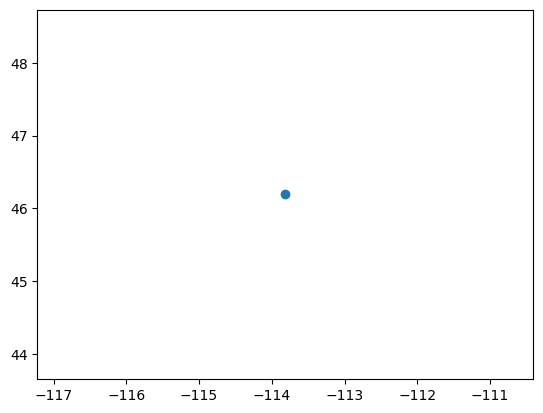

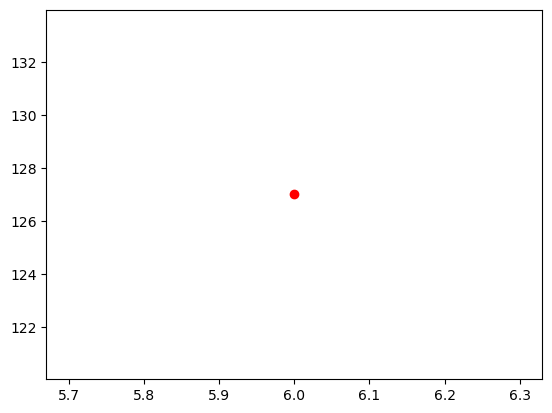

  6%|▌         | 8/131 [05:25<1:02:55, 30.70s/it]

0321_01452
WORKED: 2, ['0321_01452']
worked:  0321_03136


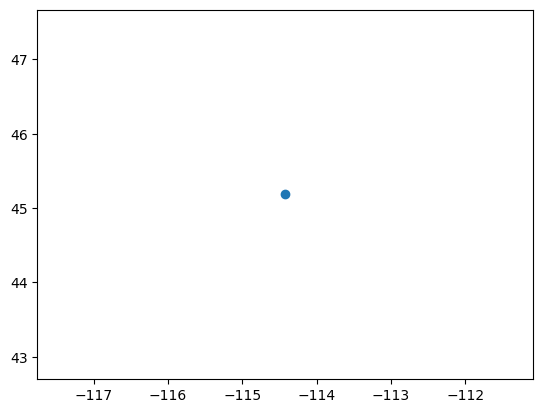

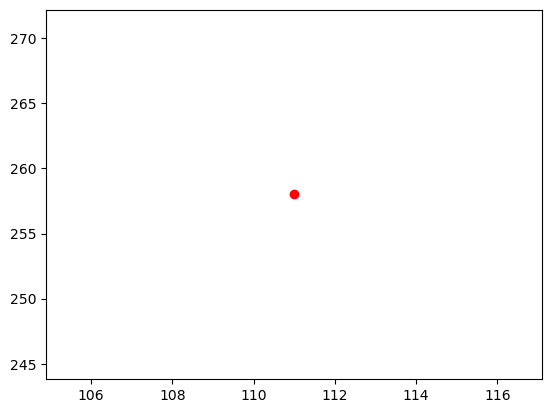

  8%|▊         | 10/131 [07:25<1:27:42, 43.49s/it]

0269_00543
WORKED: 3, ['0269_00543']
worked:  0269_00642


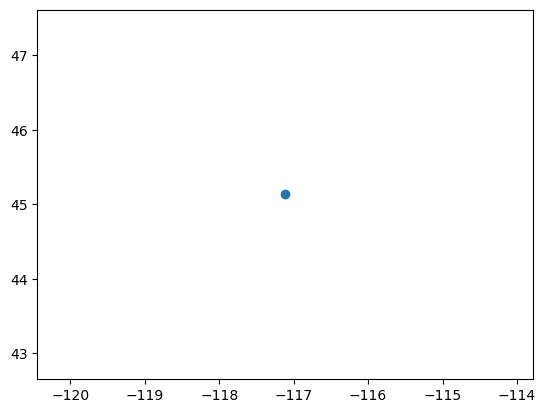

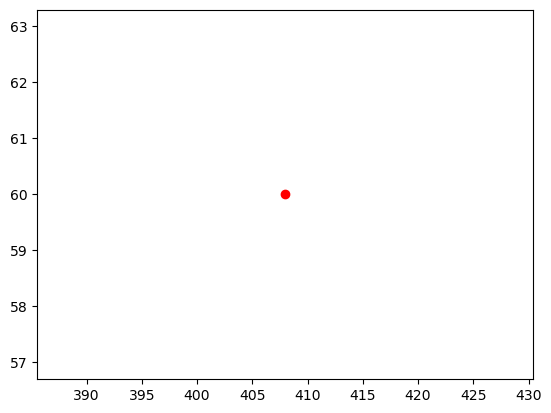

  9%|▉         | 12/131 [07:50<55:22, 27.92s/it]  

0347_00495
WORKED: 4, ['0347_00495']
worked:  0347_00907


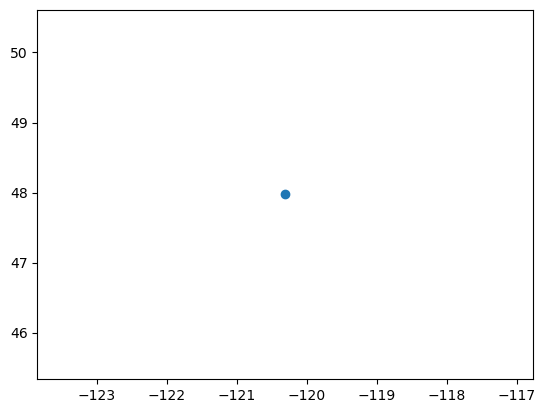

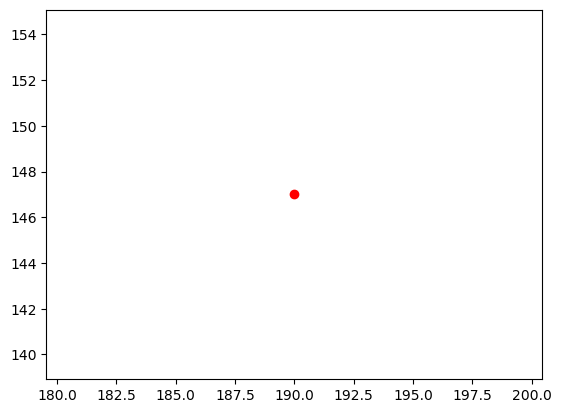

 15%|█▍        | 19/131 [11:09<49:42, 26.63s/it]

0319_04119
WORKED: 5, ['0319_04119']
worked:  0319_04796


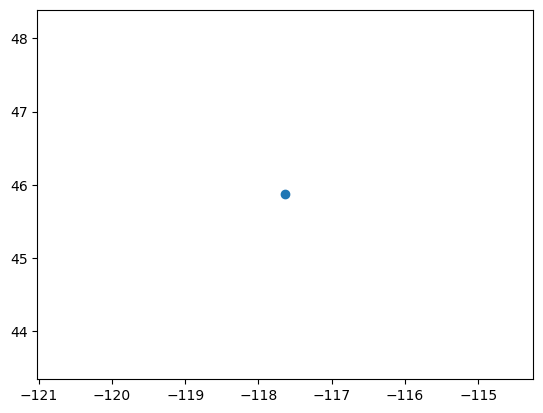

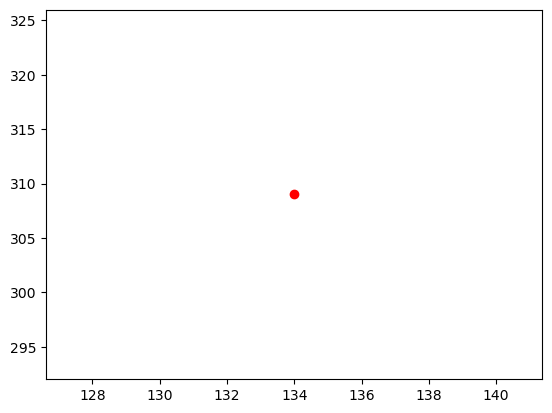

 17%|█▋        | 22/131 [14:52<1:35:32, 52.59s/it]

Scenario 0085_01420 has the wrong size for layout 0085_02466: 334 != 351 or 241 != 250
0320_00682
WORKED: 6, ['0320_00682']
worked:  0320_02378


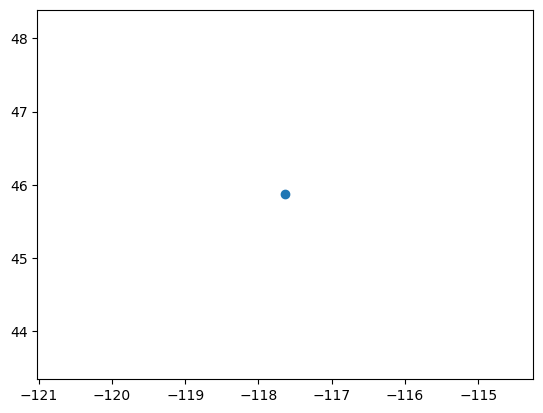

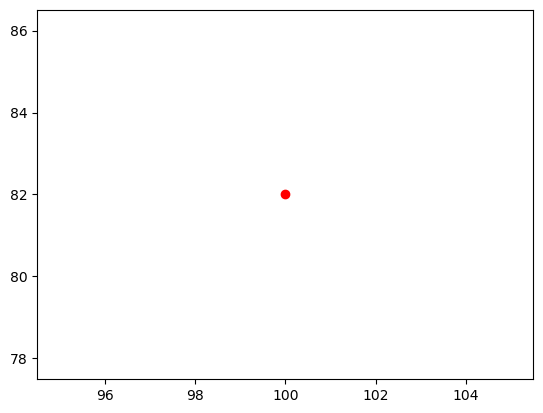

 20%|█▉        | 26/131 [17:03<1:00:41, 34.68s/it]

0035_00081
WORKED: 7, ['0035_00081']
worked:  0035_00642


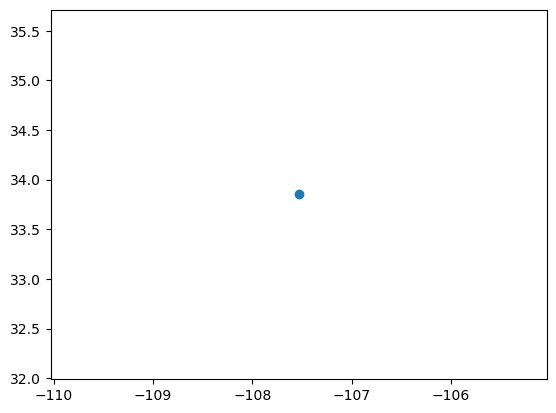

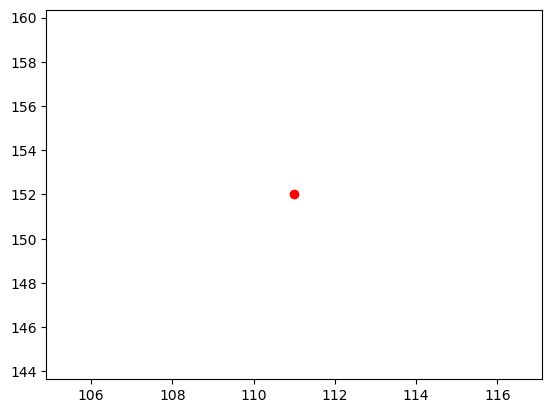

 21%|██▏       | 28/131 [17:59<56:30, 32.92s/it]  

0343_00672
WORKED: 8, ['0343_00672']
worked:  0343_03272


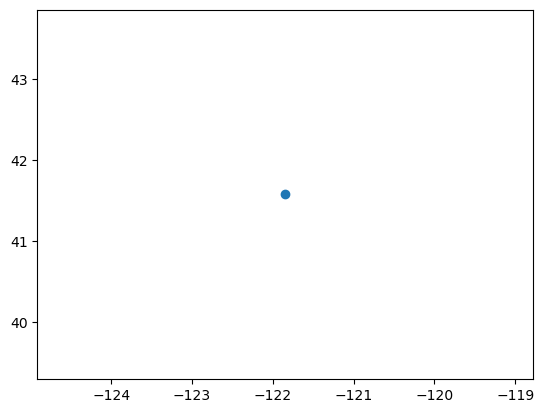

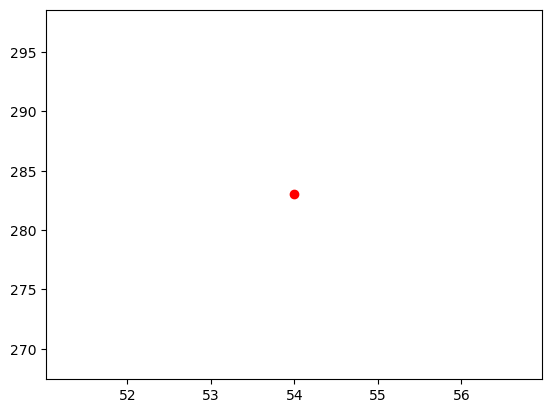

 24%|██▍       | 32/131 [20:52<1:04:04, 38.84s/it]

Error for layout 0312_02933: No JPG files found in folder: ./WideDataset/0312_02933/Satellite_Images_Mask/0312_02522/
0323_00687
WORKED: 9, ['0323_00687']
worked:  0323_01406


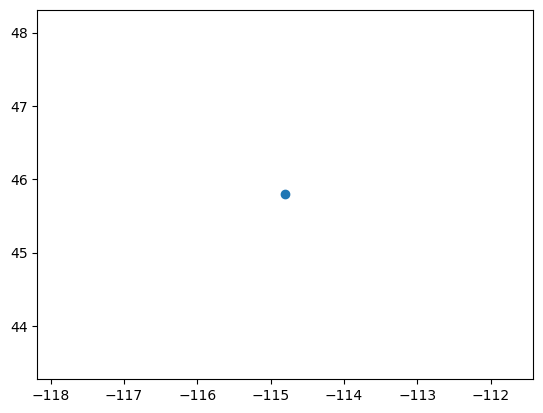

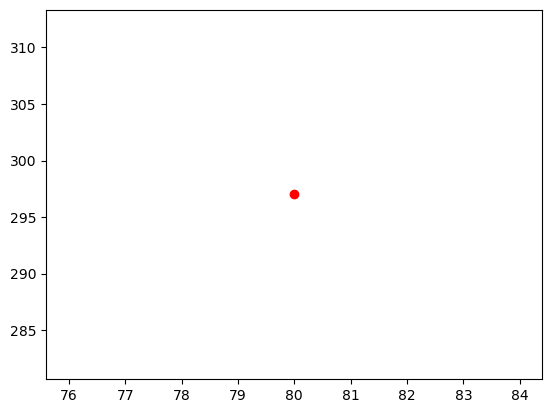

 27%|██▋       | 36/131 [22:52<49:22, 31.19s/it]  

0264_00356
WORKED: 10, ['0264_00356']
worked:  0264_02426


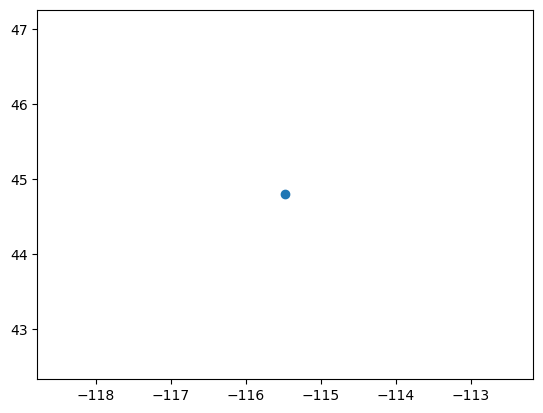

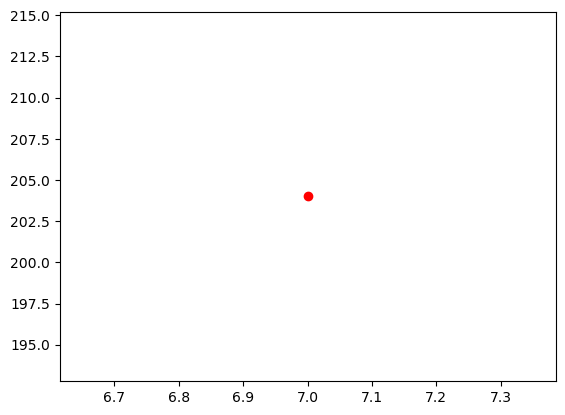

 29%|██▉       | 38/131 [24:35<1:03:09, 40.75s/it]

0278_00881
WORKED: 11, ['0278_00881']
worked:  0278_01323


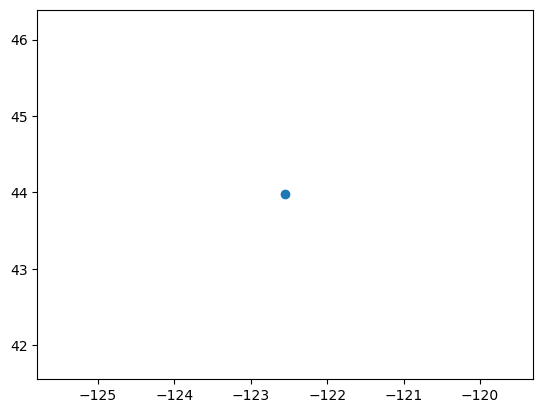

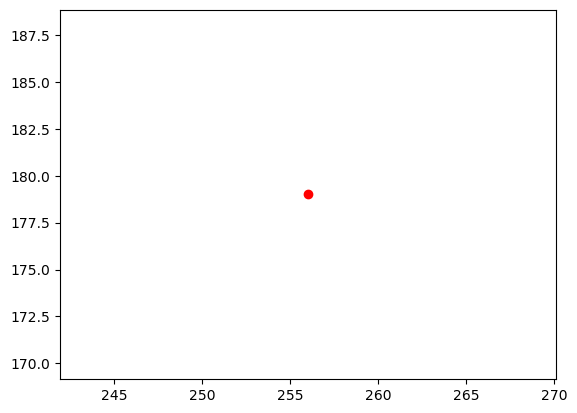

 31%|███▏      | 41/131 [25:44<45:00, 30.01s/it]  

0265_01140
WORKED: 12, ['0265_01140']
worked:  0265_02487


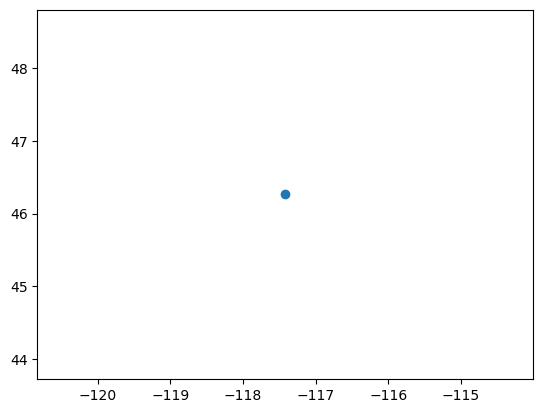

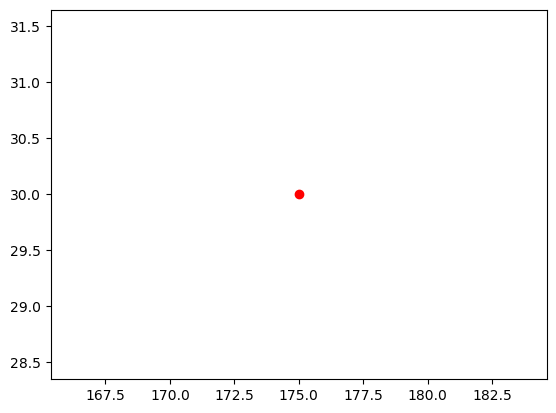

 33%|███▎      | 43/131 [27:09<50:47, 34.63s/it]

Layout ./WideDataset/0110_02767/Satellite_Images_Mask/ does not exist


 35%|███▌      | 46/131 [28:38<47:46, 33.73s/it]

Scenario 0086_00265 has the wrong size for layout 0086_02230: 429 != 263 or 445 != 309


 36%|███▌      | 47/131 [29:41<59:27, 42.47s/it]

Scenario 0021_00115 has the wrong size for layout 0087_02445: 429 != 267 or 445 != 285


 37%|███▋      | 48/131 [30:00<49:01, 35.44s/it]

Layout ./WideDataset/0109_03065/Satellite_Images_Mask/ does not exist


 40%|████      | 53/131 [32:02<33:52, 26.05s/it]

0337_01635
WORKED: 13, ['0337_01635']
worked:  0337_02831


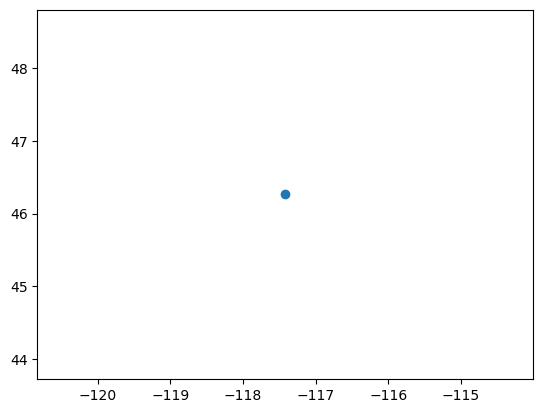

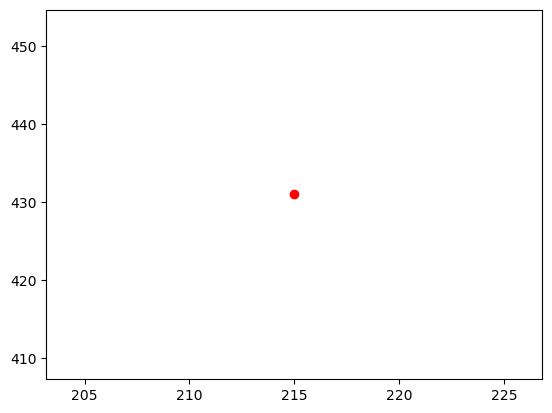

 44%|████▎     | 57/131 [34:39<40:21, 32.72s/it]

Layout ./WideDataset/0108_02258/Satellite_Images_Mask/ does not exist


 47%|████▋     | 62/131 [37:02<33:36, 29.22s/it]

Layout ./WideDataset/0106_02165/Satellite_Images_Mask/ does not exist


 49%|████▉     | 64/131 [38:03<34:40, 31.05s/it]

Layout ./WideDataset/0111_03612/Satellite_Images_Mask/ does not exist


 51%|█████     | 67/131 [39:05<24:12, 22.69s/it]

Layout ./WideDataset/0104_02422/Satellite_Images_Mask/ does not exist


 53%|█████▎    | 69/131 [39:51<23:28, 22.72s/it]

0016_02931
0016_00053
WORKED: 14, ['0016_02931', '0016_00053']
worked:  0016_03070


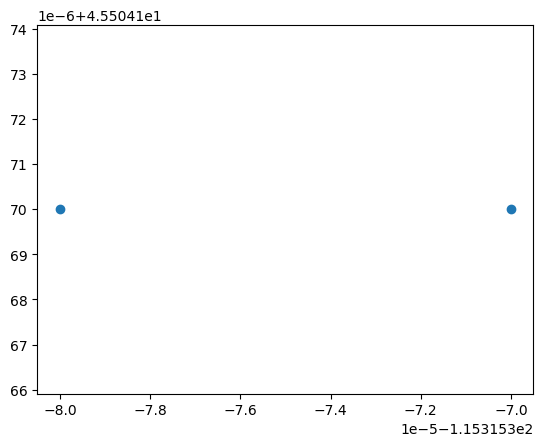

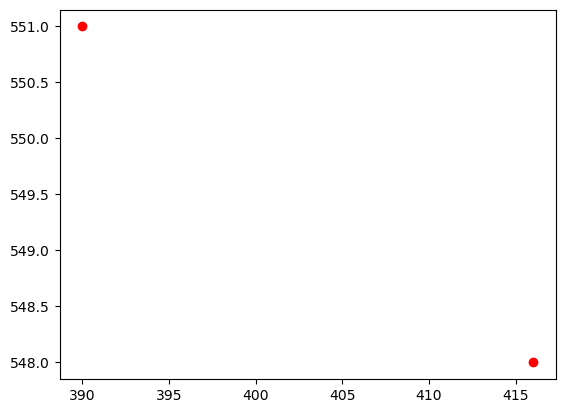

 54%|█████▍    | 71/131 [41:48<38:15, 38.25s/it]

Layout ./WideDataset/0105_03054/Satellite_Images_Mask/ does not exist


 60%|██████    | 79/131 [45:21<22:32, 26.02s/it]

Layout ./WideDataset/0243_02722/Satellite_Images_Mask/ does not exist


 69%|██████▊   | 90/131 [49:57<21:36, 31.63s/it]

Layout ./WideDataset/0064_02717/Satellite_Images_Mask/ does not exist


 71%|███████   | 93/131 [51:48<23:12, 36.64s/it]

Layout ./WideDataset/0059_02804/Satellite_Images_Mask/ does not exist


 73%|███████▎  | 95/131 [53:01<22:09, 36.93s/it]

Scenario 0102_00647 has the wrong size for layout 0102_01733: 846 != 565 or 1046 != 555


 73%|███████▎  | 96/131 [53:48<23:16, 39.91s/it]

Scenario 0103_00524 has the wrong size for layout 0103_01810: 846 != 591 or 1046 != 638


 77%|███████▋  | 101/131 [57:04<18:48, 37.63s/it]

Scenario 0090_00947 has the wrong size for layout 0090_00987: 931 != 555 or 1009 != 505
Layout ./WideDataset/0242_02940/Satellite_Images_Mask/ does not exist


 78%|███████▊  | 102/131 [57:24<15:43, 32.53s/it]

Error for layout 0245_03988: No JPG files found in folder: ./WideDataset/0245_03988/Satellite_Images_Mask/0245_03900/


 79%|███████▉  | 104/131 [58:12<12:47, 28.44s/it]

Layout ./WideDataset/0060_03010/Satellite_Images_Mask/ does not exist


 80%|████████  | 105/131 [58:32<11:28, 26.49s/it]

Layout ./WideDataset/0062_03187/Satellite_Images_Mask/ does not exist


 82%|████████▏ | 108/131 [1:00:27<12:56, 33.77s/it]

Layout ./WideDataset/0058_03866/Satellite_Images_Mask/ does not exist


 83%|████████▎ | 109/131 [1:00:55<11:46, 32.12s/it]

Layout ./WideDataset/0244_03110/Satellite_Images_Mask/ does not exist


 89%|████████▊ | 116/131 [1:06:14<13:39, 54.61s/it]

Layout ./WideDataset/0063_02387/Satellite_Images_Mask/ does not exist


 89%|████████▉ | 117/131 [1:06:46<11:09, 47.79s/it]

Layout ./WideDataset/0061_03726/Satellite_Images_Mask/ does not exist


 91%|█████████ | 119/131 [1:08:33<10:23, 51.94s/it]

Scenario 0100_01361 has the wrong size for layout 0100_02449: 1163 != 572 or 945 != 471


 92%|█████████▏| 120/131 [1:09:12<08:48, 48.01s/it]

Scenario 0098_01539 has the wrong size for layout 0098_01784: 1163 != 520 or 945 != 487


100%|██████████| 131/131 [1:13:29<00:00, 33.66s/it]

112
131
['0279_03823', '0280_03717', '0014_00426', '0321_03136', '0269_00642', '0347_00907', '0319_04796', '0085_02466', '0320_02378', '0035_00642', '0343_03272', '0323_01406', '0264_02426', '0278_01323', '0265_02487', '0086_02230', '0087_02445', '0337_02831', '0016_03070', '0102_01733', '0103_01810', '0090_00987', '0100_02449', '0098_01784']


In [12]:
from Scenario_sampler import ScenarioSamplerDate
from tqdm import tqdm
# Get the layout coordinates 
# 1 extract the tif files
dataset_path = "./WideDataset/"

# copy the layout tifs from a folder to a folder called sim2real_layout
tif_path = "sim2real_layouts"
os.makedirs(tif_path, exist_ok=True)
for folder in os.listdir(dataset_path):
    if folder == ".DS_Store":
        continue
    shutil.copy(f"WideDataset/{folder}/Vegetation_Map/Existing_Vegetation_Cover.tif", f"{tif_path}/{folder}_Existing_Vegetation_Cover.tif")

print("Copied the layout tifs to sim2real_layouts")
####

tif_files = glob(os.path.join(tif_path, "*.tif"))
layout_list = []
widths = []
names = []
for tif_file in tif_files:
    with rasterio.open(tif_file) as dataset:
        # get the file name without the path
        file_name = os.path.basename(tif_file)  # '0004_Elevation.tif'
        identifier = "_".join(file_name.split('_')[:2])

        # extract the resolution, check it is 30
        x_resolution = dataset.transform[0]
        y_resolution = -dataset.transform[4]
        assert x_resolution == y_resolution == 30, f"Resolution is not the same: {x_resolution} != {y_resolution}"

        # extract the coordinates using the bounds
        # /!\ DO NOT USE transform_bounds(dataset.crs, 'EPSG:4326', *dataset.bounds)
        x_min = dataset.bounds[0]
        x_max = dataset.bounds[2]
        y_min = dataset.bounds[1]
        y_max = dataset.bounds[3]

        transformer = Transformer.from_crs(dataset.crs, "EPSG:4326", always_xy=True)
        lat_top_left, lon_top_left = transformer.transform(x_min, y_max)
        lat_top_right, lon_top_right = transformer.transform(x_max, y_max)
        lat_bottom_left, lon_bottom_left = transformer.transform(x_min, y_min)
        lat_bottom_right, lon_bottom_right = transformer.transform(x_max, y_min)

        # Create the polygon using the transformed bounds
        polygon = Polygon((
            (lat_top_left, lon_top_left),
            (lat_top_right, lon_top_right),
            (lat_bottom_right, lon_bottom_right),
            (lat_bottom_left, lon_bottom_left),
            (lat_top_left, lon_top_left)  # close the polygon
        ))

        layout_list.append({
            'identifier': identifier,
            'height': dataset.height,
            'width': dataset.width,
            'geometry': polygon,
            'transformer': transformer,
            'dataset': dataset
        })


        widths.append(dataset.width)
        names.append(identifier)

sorted_indices = np.argsort(widths)
widths = np.array(widths)[sorted_indices]
names = np.array(names)[sorted_indices]
filtered_layout_list = [layout_list[i] for i in sorted_indices]

n_small_layouts = len(widths[widths < 500])
n_medium_layouts = len(widths[(widths >= 500) & (widths < 1000)])
n_large_layouts = len(widths[widths >= 1000])

small_layouts = filtered_layout_list[:n_small_layouts]
medium_layouts = filtered_layout_list[n_small_layouts:n_small_layouts + n_medium_layouts]
large_layouts = filtered_layout_list[n_small_layouts + n_medium_layouts:]

print("loaded the layout list")


# convert the layout list to a geopandas df
gdf = gpd.GeoDataFrame(layout_list, geometry='geometry', crs="EPSG:4326")




# Load the historical fires 
# fires_gdf = gpd.read_file("./FPA_FOD_20210617.gpkg")
# fires_gdf = fires_gdf.to_crs("EPSG:4326")
print("loaded the fires")


# Joint
# Spatial join: find which points fall into which polygons
joined = gpd.sjoin(new_fires_gdf, gdf, how='inner', predicate='within')


# Count points per polygon
counts = joined.groupby('identifier').size().reset_index(name='fire_count')
print(counts)


dataset_path = "./WideDataset/"
scenario_path_suffix = "/Satellite_Images_Mask/"

failed_layouts = []
processed_layouts = []
continue_out = False
processed = total = 0
WORKED = 0

for layout_name in tqdm(names):
    total+=1
    #print(layout_name)
    try:
        layout_folder = dataset_path + layout_name + scenario_path_suffix
        # check the layout folder exists
        if not os.path.exists(layout_folder):
            print(f"Layout {layout_folder} does not exist")
            layout_folder = dataset_path + layout_name +  "/Satellite_Image_Mask/"
            if not os.path.exists(layout_folder):
                print(f"Layout {layout_folder} does not exist")
                failed_layouts.append(layout_name)
                continue
        
        if os.path.exists(f"./WideDataset/{layout_name}/selected_scenarios.txt"):
            processed +=1
            #continue

        # check that the scenario have the right size
        first_scenario = return_first_scenario(layout_folder)
        if first_scenario is None:
            print(f"Layout {layout_name} does not have any scenario")
            failed_layouts.append(layout_name)
            continue
        
        first_loaded_scenario = load_scenario(os.path.join(layout_folder, first_scenario), extension = '.jpg', first_frame_only=True)
        height_scenario, width_scenario = first_loaded_scenario.shape[0], first_loaded_scenario.shape[1]

        earliest_date, latest_date = find_earliest_latest_dates(dataset_path + layout_name)

        # if earliest_date.year > 2020:
        #     print(f"Layout {layout_name} has no fires before 2021: {earliest_date}")
        #     failed_layouts.append(layout_name)
        #     continue

        # plot the historical fires
        data = joined[joined['identifier'] == layout_name]

        filtered_data = data[
        (data['DISCOVERY_DATE'].dt.date >= earliest_date.date()) & 
        (data['DISCOVERY_DATE'].dt.date <= latest_date.date())
        ]
        n_data = len(filtered_data)
        if n_data == 0:
            #print(f"No fires found for layout {layout_name} between {earliest_date} and {latest_date}")
            # if len(data) != 0:  
            #     print("example  fire date:", data['DISCOVERY_DATE'].iloc[0])
            failed_layouts.append(layout_name)
            continue


        sampler = ScenarioSamplerDate(layout_folder, extension = '.jpg')
        sampled_scenarios = []
        sampled_ignition_points = []
        sampled_ignition_dates = []
        associated_fires = []
        date_matched = []
        distances = []
        failed = 0
        

        #plt.scatter(filtered_data["LONGITUDE"], filtered_data["LATITUDE"])
        #plt.axis("equal")
        #plt.show()

        # start with the fires that have potewntial to be test fires, i.e their date is between the earliest and latest date
        # We will have one "test" dataset, one "train" dataset, and one extra train dataset for the test fires

        

        for i, fire in filtered_data.iterrows():
            # print the coordinates of the fire
            width, height = fire['width'], fire['height']
            # check that the scenario have the right size
            if width != width_scenario or height != height_scenario:
                print(f"Scenario {first_scenario} has the wrong size for layout {layout_name}: {width} != {width_scenario} or {height} != {height_scenario}")
                failed_layouts.append(layout_name)
                n_data = 0 
                break
            dataset = fire['dataset']
            transformer = fire['transformer']
            x_fire, y_fire = transformer.transform(fire['LONGITUDE'], fire['LATITUDE'], direction='INVERSE')
            row, col = rasterio.transform.rowcol(dataset.transform, x_fire, y_fire)
            date = fire['DISCOVERY_DATE']
            # print("row, col", row, col)
            ignition_point = (row, col)
            res = sampler.get_scenario_location(ignition_point, date = fire['DISCOVERY_DATE'].date(), leeway_distance=500, leeway_date=1, sampling_method='closest', exclude_scenarios=sampled_scenarios)
            if res[0] is None:
                sample, sampled_ignition_point, sampled_ignition_date = None, None, None
            else:
                sample, sampled_ignition_point, sampled_ignition_date = res
            if sample is None:
                failed += 1
                print("we wanted to sample the fire", fire['DISCOVERY_DATE'], "at", ignition_point, "but it failed")
                #print(sampler.get_all_scenario_dates())
                #print(sampler.get_all_scenario_ignition_points())
                #print("-- surprising? --")
                #print(sampler.get_scenarios_at_a_date(fire['DISCOVERY_DATE'].date()))
                continue
            else:
                print(sample)
            sampled_scenarios.append(sample)
            sampled_ignition_points.append(sampled_ignition_point)
            sampled_ignition_dates.append(sampled_ignition_date)
            associated_fires.append(fire['OBJECTID'])
            distance = abs(sampled_ignition_point[0] - ignition_point[0]) + abs(sampled_ignition_point[1] - ignition_point[1])
            distances.append(distance)
        # plot the sampled scenarios
        # the axes are inverted as coordinates start in (0,0) in the top left corner
        #fig, ax = plt.subplots()
        #ax.scatter([point[0] for point in sampled_ignition_points], [width - point[1] for point in sampled_ignition_points], color='red')
        #plt.show()
        #print(f"Failed {failed}")
        # write the selected scenarios in a txt file
        with open(f"./WideDataset/{layout_name}/selected_scenarios_test_new_500.txt", "w") as f:
            for scenario, fire_id in zip(sampled_scenarios, associated_fires):
                f.write(f"{scenario}, {fire_id}\n")
            f.write(f"Failed: {failed}\n")
            failed_percentage = failed / max(n_data,1)
            f.write(f"Failed percentage: {failed_percentage}\n")
            #print(f"Layout {layout_name}: {n_data} fires, {failed} failed, {failed_percentage}")
            processed_layouts.append(layout_name)
        if n_data != 0 and failed != n_data:
            WORKED += 1
            print(f"WORKED: {WORKED}, {sampled_scenarios}")
            print("worked: ", layout_name)
            plt.scatter(filtered_data["LONGITUDE"], filtered_data["LATITUDE"])
            plt.axis("equal")
            plt.show()
            fig, ax = plt.subplots()
            ax.scatter([point[0] for point in sampled_ignition_points], [width - point[1] for point in sampled_ignition_points], color='red')
            plt.show()
        if n_data != 0 and failed_percentage > 0.2:
            print(f"!! Failed {failed} out of {n_data} for layout {layout_name} !!")
            failed_layouts.append(layout_name)
    except Exception as e:
        print(f"Error for layout {layout_name}: {e}")
        failed_layouts.append(layout_name)
print(processed)
print(total)
print(processed_layouts)
    

# TODO do we need to create the grid manually? I think the raster file will doirectly give you the coordinates within the layout


# for each fire, sample the scenario (space only, and time+space)
# write the identifier in a txt file (one for space only, one for time+space)

# move the scenarios into a selected folder
# "delete" the other scenarios

# train test split with the date









In [28]:
print(len(new_fires_gdf['OBJECTID'].unique()))
print(len(new_fires_gdf))

581759
581759
